<a href="https://colab.research.google.com/github/asanis/testcode/blob/main/IDS_with_IPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
# Φόρτωμα του dataset
df = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/EKPA/refs/heads/main/Data/pcap_data.csv')

In [3]:
# Χαρακτηριστικά και target
X = df.drop('target', axis=1).values  # Χαρακτηριστικά (features)
y = df['target'].values  # Ετικέτες (target)

In [4]:
# Κανονικοποίηση των δεδομένων
dmin = X.min(axis=0)
dmax = X.max(axis=0)
X = (X - dmin) / (dmax - dmin)


In [5]:
# Επαναδιατύπωση των labels με τις νέες κατηγορίες
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [6]:
# Διαχωρισμός δεδομένων σε train και test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Υπολογισμός των class weights για τις κατηγορίες
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),  # Χρησιμοποιούμε τις μοναδικές τιμές του y_train
    y=y_train
)

In [8]:
# Δημιουργία λεξικού με τα βάρη των κατηγοριών
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

In [9]:
# Δημιουργία του μοντέλου
model = models.Sequential()

In [10]:
# Προσθήκη του πρώτου επιπέδου
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Προσθήκη ενός dropout layer
model.add(layers.Dropout(0.5))

In [12]:
# Προσθήκη δεύτερου επιπέδου
model.add(layers.Dense(64, activation='relu'))

In [13]:
# Προσθήκη ενός ακόμα dropout layer
model.add(layers.Dropout(0.5))

In [14]:
# Προσθήκη εξόδου με 3 κατηγορίες (3 κατηγορίες, γιατί το target έχει τιμές 0, 1, 2)
model.add(layers.Dense(3, activation='softmax'))  # 3 κατηγορίες, χρησιμοποιούμε softmax


In [15]:
# Σύνθεση του μοντέλου με την κατάλληλη συνάρτηση απώλειας και βελτιστοποιητή
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Για sparse κατηγορίες (όχι one-hot encoding)
              metrics=['accuracy'])


In [16]:
# Εκπαίδευση του μοντέλου με τα class weights
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_test, y_test),
    class_weight=class_weights
)


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3777 - loss: 1.0972 - val_accuracy: 0.6383 - val_loss: 0.9862
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5331 - loss: 0.9808 - val_accuracy: 0.7305 - val_loss: 0.8019
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6741 - loss: 0.8147 - val_accuracy: 0.7735 - val_loss: 0.6567
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7305 - loss: 0.7078 - val_accuracy: 0.8016 - val_loss: 0.5874
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7595 - loss: 0.6469 - val_accuracy: 0.8236 - val_loss: 0.5435
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7860 - loss: 0.5909 - val_accuracy: 0.8310 - val_loss: 0.5211
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8011 - loss: 0.5733 - val_accuracy: 0.8407 - val_loss: 0.5017
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8047 - loss: 0.5602 - val_accuracy: 0.8547 - v

In [17]:
# Αξιολόγηση του μοντέλου στο δοκιμαστικό σύνολο
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9104 - loss: 0.3492
Test accuracy: 0.9061456322669983


In [18]:
# Συνάρτηση για τις προληπτικές ενέργειες
def take_preventive_action(prediction):
    # Απειλές 1 ή 2
    threat_level = {
        0: "Normal",  # Χαμηλή απειλή (Normal)
        1: "Medium Threat",  # Μέτρια απειλή
        2: "High Threat"  # Υψηλή απειλή
    }

    if prediction == 2:
        # Υψηλή απειλή: Ενεργοποιούμε μέτρα όπως φιλτράρισμα ή απομόνωση
        print("High threat detected! Taking preventive actions...")
        #  Κώδικας που κάνει απομόνωση συστήματος ή φιλτράρισμα
    elif prediction == 1:
        # Μέτρια απειλή: Ειδοποίηση πχ. email alert
        print("Medium threat detected. Monitoring activity...")
        # Ειδοποίηση
    else:
        # Χαμηλή απειλή ή καμία
        print("No threat detected. Normal activity.")

In [19]:
# Προβλέψεις για τα δεδομένα
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Επιλέγουμε την κλάση με τη μεγαλύτερη πιθανότητα

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [20]:
# Για κάθε πρόβλεψη, αναλαμβάνουμε προληπτική δράση
for prediction in y_pred_classes:
    take_preventive_action(prediction)

No threat detected. Normal activity.
No threat detected. Normal activity.
High threat detected! Taking preventive actions...
No threat detected. Normal activity.
No threat detected. Normal activity.
High threat detected! Taking preventive actions...
High threat detected! Taking preventive actions...
No threat detected. Normal activity.
High threat detected! Taking preventive actions...
No threat detected. Normal activity.
No threat detected. Normal activity.
High threat detected! Taking preventive actions...
No threat detected. Normal activity.
No threat detected. Normal activity.
High threat detected! Taking preventive actions...
No threat detected. Normal activity.
No threat detected. Normal activity.
No threat detected. Normal activity.
High threat detected! Taking preventive actions...
Medium threat detected. Monitoring activity...
High threat detected! Taking preventive actions...
High threat detected! Taking preventive actions...
No threat detected. Normal activity.
High threat d

In [21]:
# Ανάκτηση των αποτελεσμάτων εκπαίδευσης
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


In [22]:
# Εμφάνιση των αποτελεσμάτων γραφικά
import matplotlib.pyplot as plt

epochs = range(len(acc))

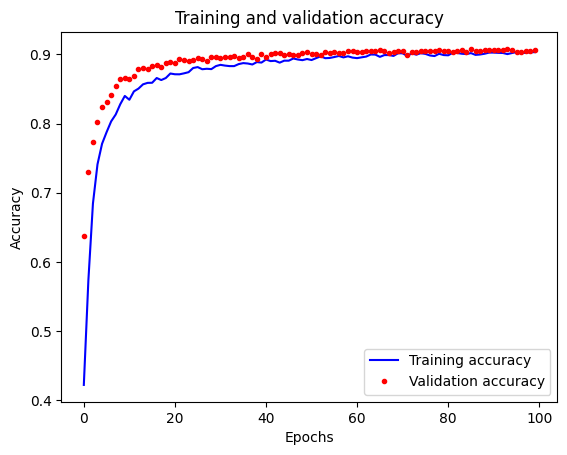

In [23]:
# Plot accuracy
plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r.', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

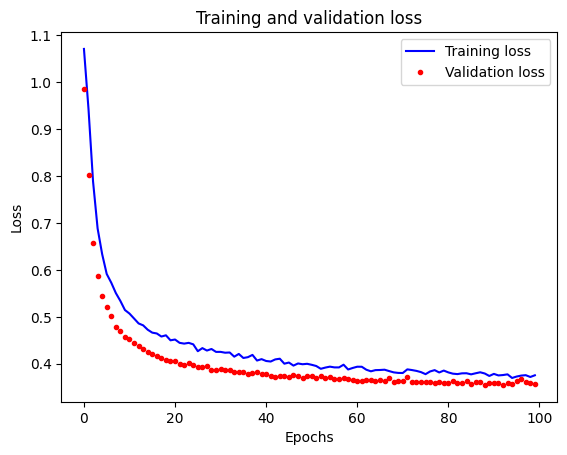

In [24]:
# Plot loss
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()